# Introducción a PyMC

Nota: Este texto es una traducción y adaptación del [articulo introductorio a PyMC](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html)

## Resumen

La programación probabilística permite, entre otras cosas, realizar inferencia Bayesiana automática en modelos probabilistas definidos por el usuario. El algoritmo de Hamiltonian Monte Carlo (HMC), el cual es una variante de las cadenas de Markov Monte Carlo (MCMC por sus siglas en inglés) permite realizar inferencia Bayesiana en modelos de alta complejidad (entendida esta como el número de parámetros). Sin embargo, el uso de esta técnica esta supeditado al computo de los gradientes de las distribuciones, los cuales suelen ser no triviales de calcular.

PyMC es un ambiente de programación probabilística de código abierto con base en Python, Utiliza Theano (v3.0), Aesara (4.0) y PyTensor (v5.0) para el cálculo de gradientes via diferenciación automática. Permite especificar modelos utilizando código Python, lo cual lo hace fácil de aprender, manipular y dubugear. A continuación veremos una introducción a PyMC para aquellos ya familiarizados con la estadística Bayesiana. 


## Introducción
La programación probabilística (PP) permite la creación de modelos estadísticos Bayesianos de una forma flexible. PyMC es un ambiente de PP con una interfaz intuitiva y de fácil lectura, con una poderosa sintaxis que es similar a la utilizada por los estadísticos para la descripción de modelos paramétricos probabilistas. El motor de la inferencia son los algoritmos MCMC de ultima generación, como el No-U-Turn Sampler (NUTS; [Hoffman, 2014](https://jmlr.org/papers/volume15/hoffman14a/hoffman14a.pdf)), el cual es una variante autoajustable de Hamiltonian Monte Carlo (HMC; [Duane, 1987](https://ui.adsabs.harvard.edu/abs/1987PhLB..195..216D/abstract)). Este tipo de muestreadores trabajan bien en distribuciones a posteriori complejas y de alta dimensionalidad. Esto permite resolver un amplio abanico de modelos sin necesidad de una conocimiento especializado en el ajuste de modelos. HMC y NUTS utilizan los gradientes de la verosimilitud para tener una ajuste fino de los parámetros y lograr una convergencia mucho más rápida y eficiente que los métodos tradicionales de muestreo.

Además, la PP en Python tiene amplias ventajas como por ejemplo su uso en múltiples plataformas (Mac, Windows, Linux), una sintaxis clara, una fácil integración con otras librerías científicas, así como su extensión a otros lenguajes de programación como C, C++, Fortran y Cython. Estas ventajas y su flexibilidad permiten la creación de distribuciones estadísticas por el usuario como es requerido en el análisis Bayesiano.

A continuación veremos el uso de PyMC para resolver problemas generales de inferencia Bayesiana. Primero veremos como resolver el problema simple de una regresión lineal y a continuación mostraremos dos problemas que requieren modelos más sofisticados. Para problemas más complejos y ejemplos concretos ver la documentación de PyMC (en inglés).

## Un ejemplo motivador: Regresión lineal

Para introducir la definición de modelos, su ajuste y análisis posterior, vamos a comenzar con un modelo Bayesiano de regresión lineal. Utilizaremos distribuciones a priori normales y univariadas en cada parámetro.

Utilizaremos el ejemplo del artículo de David Hogg ([Hogg+2010](https://arxiv.org/abs/1008.4686)) visto anteriormente. Estamos interesados en predecir la variable $y$ como observaciones distribuidas de forma normal cuya media esta dada por una función lineal del predictor $x$, con una incertidumbre observacional $\sigma_y$. 

$$\begin{aligned} 
y  &\sim \mathcal{N}(\mu, \sigma_y) \\
\mu &= ax+b
\end{aligned}$$

dónde $a$ es la pendiente y $b$ la ordenada al origen. Utilizaremos un prior poco informativo con distribuciones normales e independientes para los parámetros $a$ y $b$.

$$\begin{aligned} 
a &\sim \mathcal{N}(0, 10) \\
b &\sim \mathcal{N}(0, 100)
\end{aligned}$$

### Datos

Utilizaremos el conjunto de datos provisto en el artículo de Hogg+2010. Como en casos anteriores, descartaremos los primeros cuatro puntos y despreciaremos la incertidumbre en $x$ y las correlaciones $\rho_{xy}$.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as st

import arviz as az  # conda install -c conda-forge arviz==0.11
import seaborn as sns # Para dibujar distribuciones con poco código
sns.set(color_codes=True)

In [2]:
%config InlineBackend.figure_format = 'retina'
#az.style.use("arviz-darkgrid")

In [3]:
# cut & pasted directly from the fetch_hogg2010test() function
# identical to the original dataset as hardcoded in the Hogg 2010 paper

dfhogg = pd.DataFrame(
    np.array(
        [
            #[1, 201, 592, 61, 9, -0.84],
            #[2, 244, 401, 25, 4, 0.31],
            #[3, 47, 583, 38, 11, 0.64],
            #[4, 287, 402, 15, 7, -0.27],
            [5, 203, 495, 21, 5, -0.33],
            [6, 58, 173, 15, 9, 0.67],
            [7, 210, 479, 27, 4, -0.02],
            [8, 202, 504, 14, 4, -0.05],
            [9, 198, 510, 30, 11, -0.84],
            [10, 158, 416, 16, 7, -0.69],
            [11, 165, 393, 14, 5, 0.30],
            [12, 201, 442, 25, 5, -0.46],
            [13, 157, 317, 52, 5, -0.03],
            [14, 131, 311, 16, 6, 0.50],
            [15, 166, 400, 34, 6, 0.73],
            [16, 160, 337, 31, 5, -0.52],
            [17, 186, 423, 42, 9, 0.90],
            [18, 125, 334, 26, 8, 0.40],
            [19, 218, 533, 16, 6, -0.78],
            [20, 146, 344, 22, 5, -0.56],
        ]
    ),
    columns=["id", "x", "y", "sigma_y", "sigma_x", "rho_xy"],
)

dfhogg["id"] = dfhogg["id"].apply(lambda x: "p{}".format(int(x)))
dfhogg.set_index("id", inplace=True)
dfhogg.head()


,x,y,sigma_y,sigma_x,rho_xy
id,,,,,
p5,203.0,495.0,21.0,5.0,-0.33
p6,58.0,173.0,15.0,9.0,0.67
p7,210.0,479.0,27.0,4.0,-0.02
p8,202.0,504.0,14.0,4.0,-0.05
p9,198.0,510.0,30.0,11.0,-0.84


Pintamos los datos.

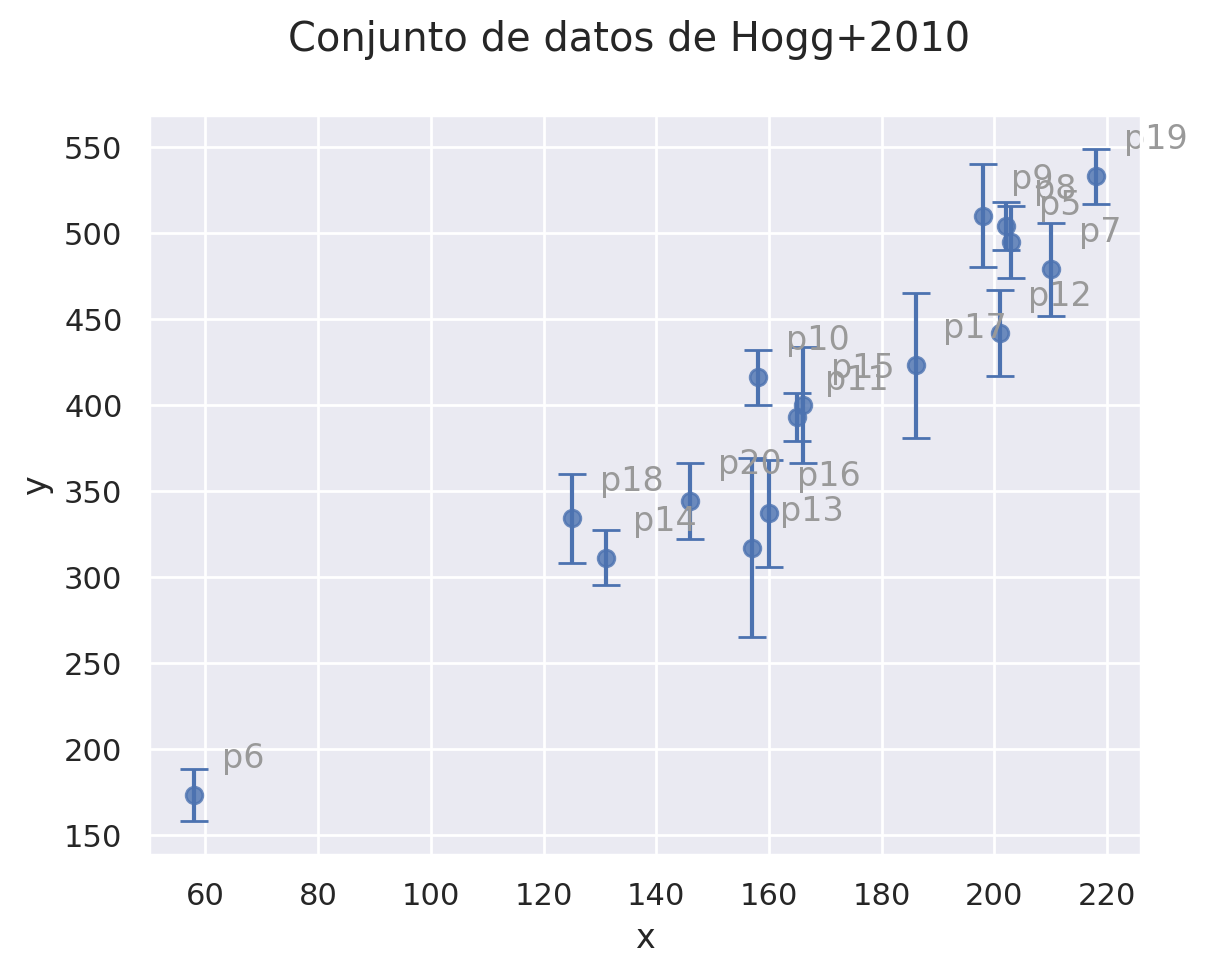

In [4]:
fig, ax = plt.subplots()
sns.regplot(data=dfhogg,x="x",y="y",fit_reg=False, ax=ax)
ax.errorbar(dfhogg["x"], dfhogg["y"], yerr=dfhogg["sigma_y"], fmt='none', capsize=5, zorder=1, color='C0')

for idx, r in dfhogg.iterrows():
    ax.annotate(
        text=idx,
        xy=(r["x"], r["y"]),
        xycoords="data",
        xytext=(10, 10),
        textcoords="offset points",
        color="#999999",
        zorder=1,
        )
_ = fig.suptitle("Conjunto de datos de Hogg+2010")

### Como especificar los modelos

Crear modelos estadísticos Bayesianos en PyMC es simple.
En la mayoría de los casos, cada linea de código Python corresponde a una linea del modelo.

Comenzamos por importar `pymc` como `pm`. Veamos que versión tenemos.

In [5]:
import pymc as pm

print(f"Running on PyMC v{pm.__version__}")

Running on PyMC v5.10.0


Creamos el modelo completo.

In [6]:
basic_model = pm.Model()

with basic_model:

    # Prior independiente para cada parámetro.
    a = pm.Normal("a", mu=0, sigma=10)
    b = pm.Normal("b", mu=0, sigma=100)
    #c = pm.Normal("c", mu=0, sigma=10)

    # Valor esperado
    y = a * dfhogg["x"] + b #+ c*dfhogg["x"]*dfhogg["x"]

    # Verosimilitud de las observaciones
    y_obs = pm.Normal("y_obs", mu=y, sigma=dfhogg["sigma_y"], observed=dfhogg["y"])

La primera linea

```python
basic_model = pm.Model()
```

crea una nueva clase: el objeto `~pymc.Model`. Este último es un contenedor para el modelo de variables aleatorias.

Una vez creado el contenedor, la definición de las variables se crea dentro de él a través del `with`.

```
with basic_model:
```
Esta linea crea el *contexto*, el cual incluirá todas las definiciones en bloques indentados. Esto significa que todos las definiciones incluidas en el bloque indentado dentro del `with` se agregan al modelo (en un detrás de cámaras). Si intentamos crear una variable aleatoria fuera del `with` nos dará un error por que no estará asociada a ningún modelo.

Las primeras lineas

```python
a = pm.Normal("a", mu=0, sigma=10)
b = pm.Normal("b", mu=0, sigma=100)
```
crean variables **estocásticas** aleatorias, las cuales, en este caso particular están distribuidas de forma normal. PyMC incluye las distribuciones estadísticas más [usuales](https://www.pymc.io/projects/docs/en/stable/api/distributions.html), y permite también [crear](https://www.pymc.io/projects/docs/en/stable/learn/core_notebooks/pymc_overview.html#arbitrary-distributions) nuestras propias distribuciones. 

Las distribuciones en PyMC siguen, en su mayoría, el siguiente patrón. El nombre de la distribución (e.g. `pm.Normal`para una distribución normal). El primer argumento es siempre el *nombre* de la variable aleatoria, el cual debe (casi) siempre ser idéntico al de la variable Python asociada a ella. Los siguientes argumentos corresponden a los parámetros de la distribución y se conocen como hyper-parámetros del modelo. Otros parámetros incluyen por ejemplo, las dimensiones de la variable, sus valores iniciales o, en el caso de ser una variable observada, como en el caso de `y_obs`, los valores que toma.

En nuestro ejemplo, las dos variables aleatorias son unidimensionales y por lo tanto no es necesario especificar el parámetro `shape`, sin embargo, este puede tomar valores enteros o tuples para indicar que la variable tiene varias dimensiones. Por ejemplo, `shape=(2,3)`creará una variable aleatoria como matriz de 2 x 3.

La siguiente linea define las relaciones entre las variables aleatorias y crea una variable **determinista** a partir de variables **estocásticas**. 

```python
y = a * dfhogg["x"] + b
```
Una variable se dice determinista cuando su valor (o valores si es multidimiensional) queda completamente determinado por el valor o valores de sus variables estocásticas. Esto significa que su incertidumbre quedará también completamente especificada por la de sus variables estocásticas.

En PyMC, las variables estocásticas, las constantes y los datos pueden ser combinados de manera arbitraria a través de [operaciones](https://www.pymc.io/projects/docs/en/stable/api/math.html) y [transformaciones](https://www.pymc.io/projects/docs/en/stable/api/distributions/transforms.html). 

La linea final del modelo produce los datos como variables aleatorias.

```python
y_obs = Normal('y_obs', mu=y, sigma=dfhogg["sigma_y"], observed=dfhogg["y"])
```
Esta última es un caso especial de variable, denominada **estocástica observada** y la distribución utilizada representa la verosimilitud del modelo. Son variables idénticas a las estocásticas pero el argumento `observed` indica que han sido observada y tienen valores específicos, haciéndolas intocables por los algoritmos de ajuste u optimización. Los datos pueden ser especificados como objetos de las clases  `numpy.ndarray` o `pandas.DataFrame`.

Es importante hacer notar que en el caso de la distribución de la verosimilitud, los parámetros no toman valores fijos como en el prior, sino que son deterministas como en `mu=y`, constantes como en `sigma=dfhogg["sigma_y"]` o pueden también ser estocásticos. Esta relación de parentesco entre las variables es fundamental ya que permite explorar la relaciones de dependencia e independencia condicional entre las variables del modelo. Veremos esto más adelante en los modelos jerárquicos Bayesianos.

Veamos una representación gráfica de nuestro modelo y de las relaciones entre sus variables. En inferencia Bayesiana, este tipo de gráficos se denominan **Modelos Gráficos Probabilistas** y tienen una notación especifica llamada **[Notación de Placas](https://es.wikipedia.org/wiki/Notaci%C3%B3n_de_placas)**. Por ejemplo, en nuestro caso las variables estocásticas observadas se representan en gris, las relaciones deterministas como flechas y cuando un conjunto de variables se repite, se incluye dentro de un rectángulo especificando el numero de repeticiones.

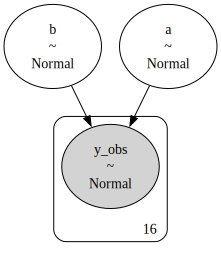

In [7]:
# conda install -c conda-forge python-graphviz
pm.model_to_graphviz(basic_model)

Una vez definido el modelo, vamos a tomar muestras utilizando el algoritmo NUTS (por defecto en PyMC) con los parámetros también por defecto (suficientes para este ejemplo).

In [8]:
with basic_model:
    # draw 1000 posterior samples
    samples = pm.sample()#draws=2000,tune=2000,target_accept=0.9) # draws=1000, tune=1000,cores=None (default in the system)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [a, b]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 3 seconds.


La linea `pm.sample` regresa un objeto **arviz.InferenceData** con las cadenas, iteraciones y variables muestreadas. Las cadenas son paralelas y tantas como especificadas en la función `sample`. Por defecto genera tantas cadenas como cores en nuestro ordenador.

In [9]:
print(samples)
print("-------------------------")
print(samples.posterior)
print("-------------------------")
print(samples.posterior["a"].to_numpy().shape)

Inference data with groups:
	> posterior
	> sample_stats
	> observed_data
-------------------------
<xarray.Dataset>
Dimensions:  (chain: 4, draw: 1000)
Coordinates:
  * chain    (chain) int64 0 1 2 3
  * draw     (draw) int64 0 1 2 3 4 5 6 7 8 ... 992 993 994 995 996 997 998 999
Data variables:
    a        (chain, draw) float64 2.298 2.267 2.204 2.293 ... 2.373 2.347 2.122
    b        (chain, draw) float64 23.35 21.26 41.05 28.72 ... 21.5 6.903 44.19
Attributes:
    created_at:                 2023-12-01T11:03:55.282803
    arviz_version:              0.16.1
    inference_library:          pymc
    inference_library_version:  5.10.0
    sampling_time:              2.560337781906128
    tuning_steps:               1000
-------------------------
(4, 1000)


### Análisis

Dibujaremos y analizaremos los resultados con [Arviz](https://python.arviz.org/en/stable/index.html), que es un código muy util para explorar y analizar resultados MCMC. Además permite trabajar con los resultados de muy distintos muestreadores. Pintemos las cadenas y las distribuciones marginales de los parámetros en nuestro modelo de regresión lineal.

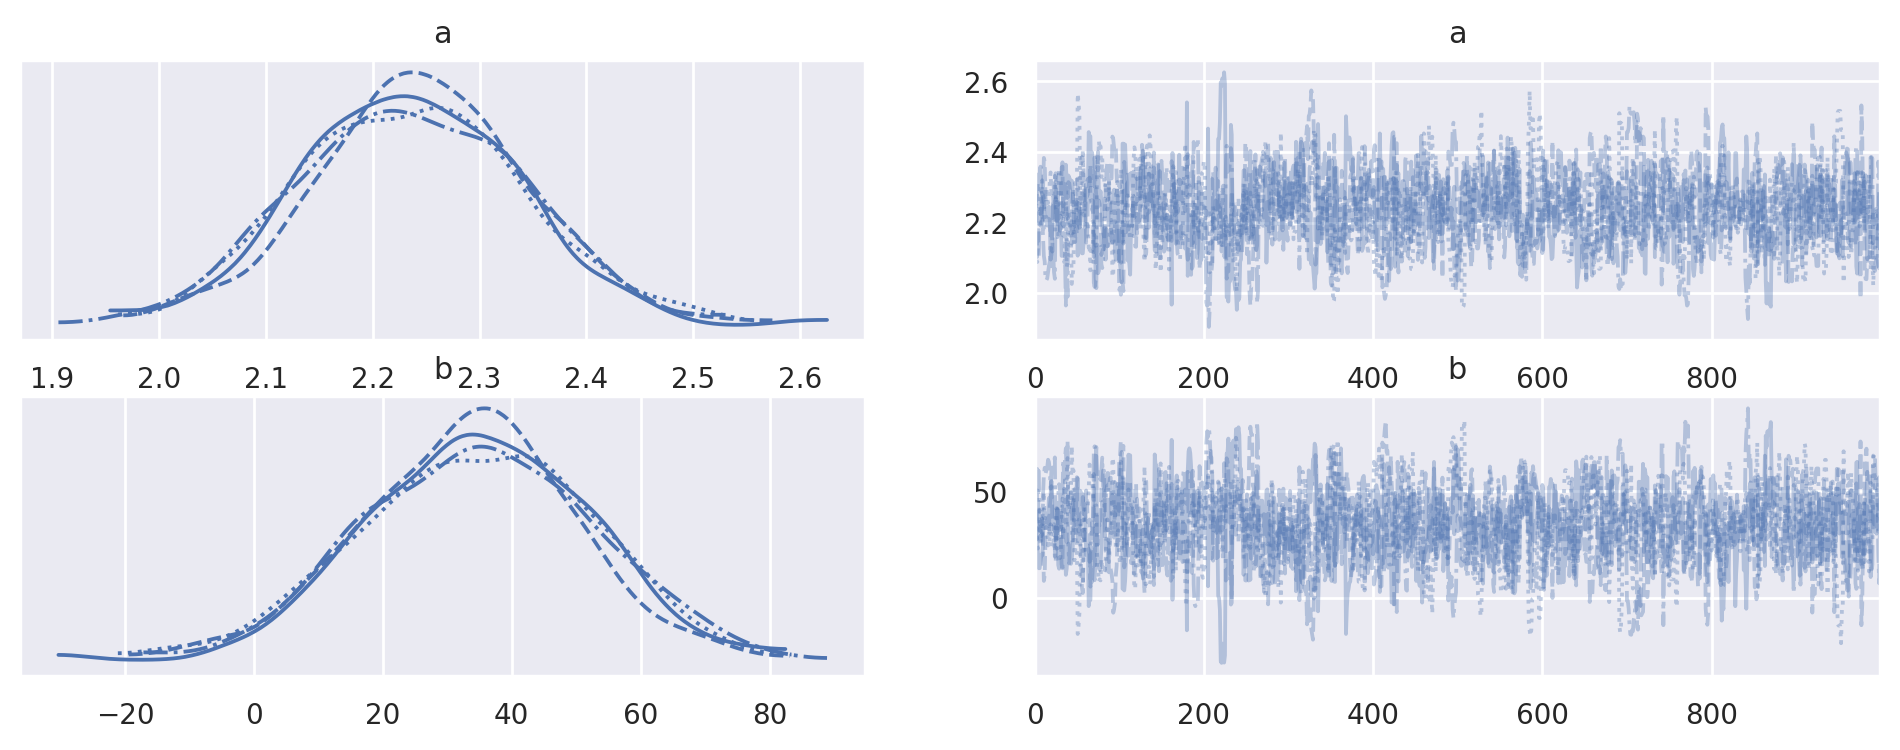

In [10]:
with basic_model:
    az.plot_trace(samples, combined=False)

En la gráfica anterior, la columna izquierda es una estimación por KDE de las marginales de cada parámetro de la distribución posterior. En la columna derecha se tienen las muestras de la cadena de Markov en orden secuencial. Nótese como al especificar `combined=False` pintamos cada una de las cadenas. 

Vamos a ver los estadísticos de las cadenas y parámetros del modelo, para ello utilizamos la función `arviz.summary`. Estimemos además la moda de la distribución posterior o máximo-a-posteriori.

In [11]:
with basic_model:
    print(az.summary(samples, round_to=3))
    map_a = az.plots.plot_utils.calculate_point_estimate('mode', samples.posterior['a'].to_numpy())
    map_b = az.plots.plot_utils.calculate_point_estimate('mode', samples.posterior['b'].to_numpy())
    #map_c = az.plots.plot_utils.calculate_point_estimate('mode', samples.posterior['c'].to_numpy())
    hdi_a = az.hdi(samples.posterior["a"], hdi_prob=.95)
    hdi_b = az.hdi(samples.posterior["b"], hdi_prob=.95)
    #hdi_c = az.hdi(samples.posterior["c"], hdi_prob=.95)

print("\n")
print("---------- MAP ---------------")
print("a: {0:2.3f}".format(map_a))
print("b: {0:2.3f}".format(map_b))
#print("c: {0:2.3f}".format(map_c))
print("------------------------------\n")
print("---------- HDI ---------------")
print("a:",hdi_a)
print("b:",hdi_b)
#print("c:",hdi_c)
print("------------------------------")
    

     mean      sd  hdi_3%  hdi_97%  mcse_mean  mcse_sd  ess_bulk  ess_tail  \
a   2.239   0.104   2.034    2.424      0.004    0.003   773.869   823.519   
b  34.234  17.821   2.578   69.168      0.642    0.463   768.753   789.439   

   r_hat  
a  1.003  
b  1.003  


---------- MAP ---------------
a: 2.238
b: 34.078
------------------------------

---------- HDI ---------------
a: <xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    a        (hdi) float64 2.027 2.432
b: <xarray.Dataset>
Dimensions:  (hdi: 2)
Coordinates:
  * hdi      (hdi) <U6 'lower' 'higher'
Data variables:
    b        (hdi) float64 -1.007 68.97
------------------------------


Pintamos la distribución posterior de "a" y "b" conjuntamente.

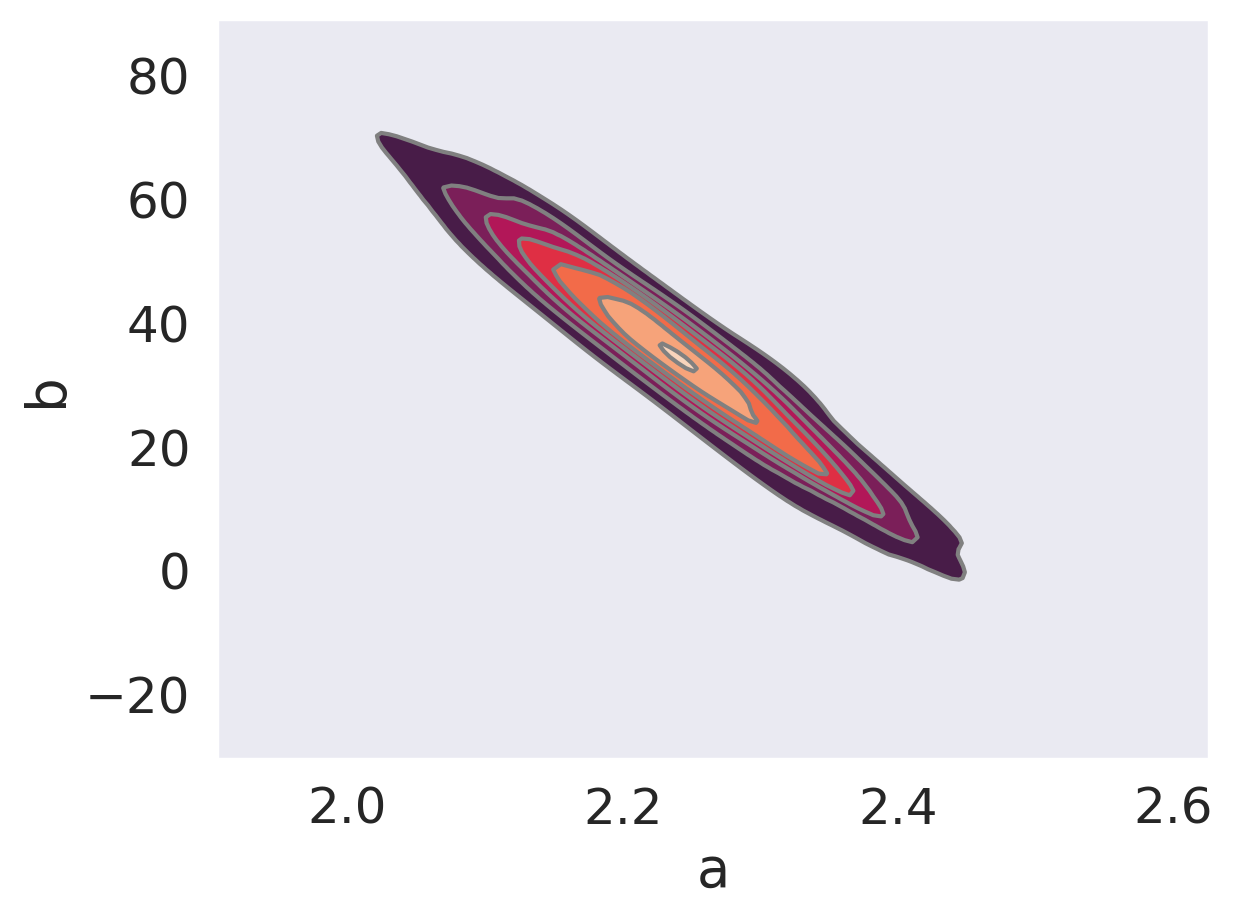

In [12]:
with basic_model:
    az.plot_pair(samples,
            var_names=['a', 'b'],
            kind='kde',
            #coords=coords,
            divergences=True,
            textsize=18)

Pintamos la distribución posterior de "a" y "b" independientemente.

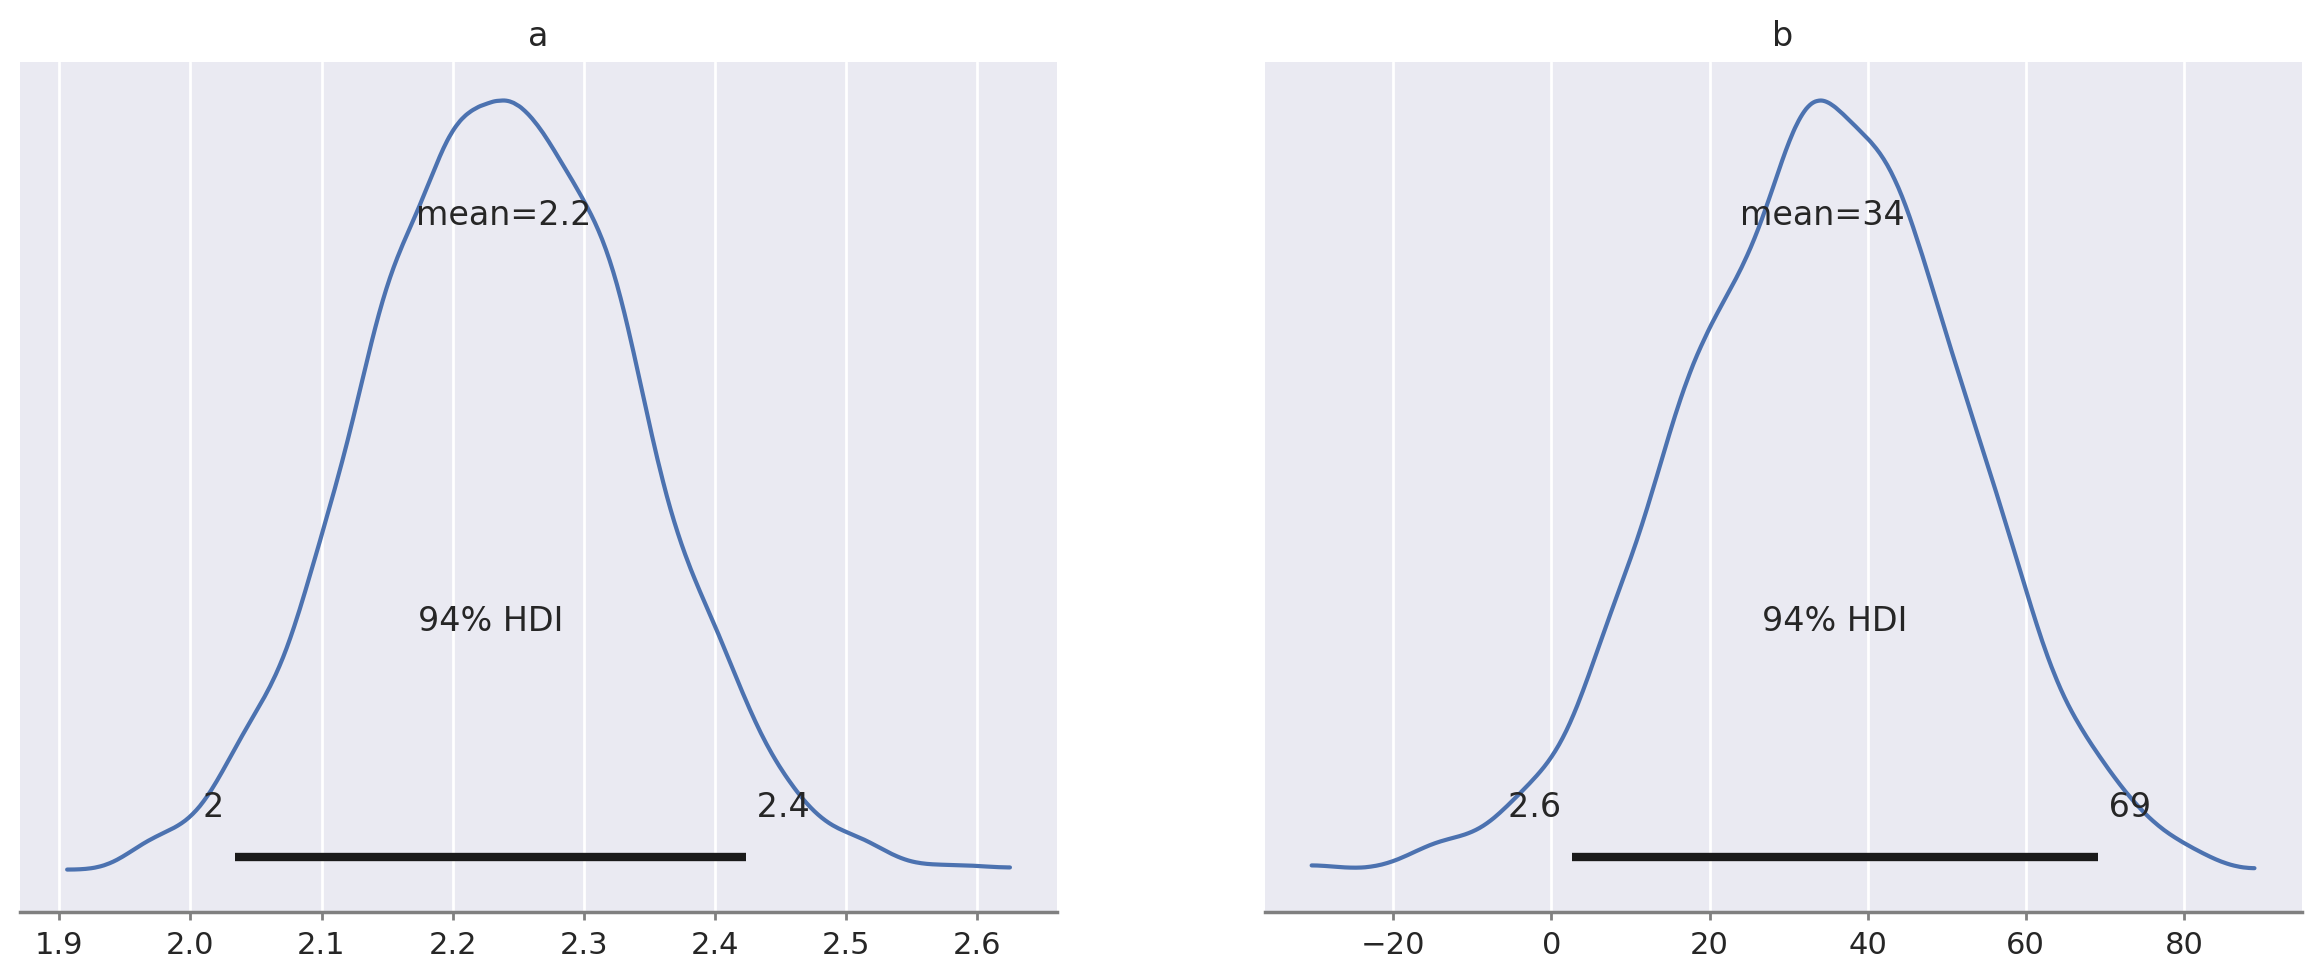

In [13]:
with basic_model:
    az.plot_posterior(samples.posterior)

Pintemos los datos, el mejor modelo y algunas muestras 

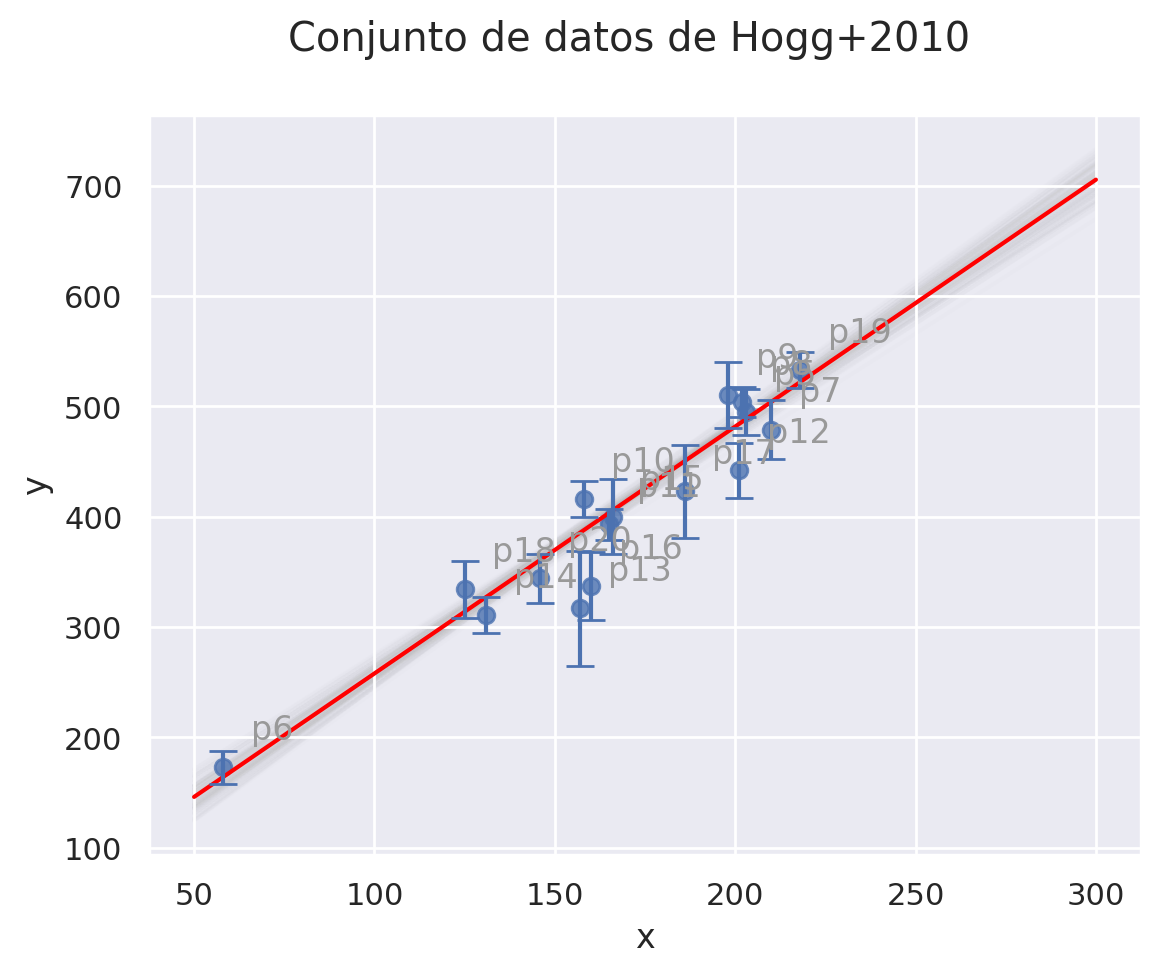

In [14]:
fig, ax = plt.subplots()
# Pintamos la muestras (incertidumbre) en gris
x = np.linspace(50,300,num=100)
smp_a = samples.posterior["a"].to_numpy().flatten()[-100:]
smp_b = samples.posterior["b"].to_numpy().flatten()[-100:]

for a,b in zip(smp_a,smp_b):
    ax.plot(x,a*x + b, color="gray", alpha=0.01,zorder=0)
    
a = sns.regplot(data=dfhogg,x="x",y="y",fit_reg=False, ax=ax)
ax.errorbar(dfhogg["x"], dfhogg["y"], yerr=dfhogg["sigma_y"], 
            fmt='none', capsize=5, zorder=2, color='C0')

for idx, r in dfhogg.iterrows():
    ax.annotate(
        text=idx,
        xy=(r["x"], r["y"]),
        xycoords="data",
        xytext=(10, 10),
        textcoords="offset points",
        color="#999999",
        zorder=3,
        )
fig.suptitle("Conjunto de datos de Hogg+2010")


ax.plot(x, map_a*x + map_b, color="red",zorder=1)

## Ejercicios

0. Modifica los parámetros del muestreo (`pm.sample()`) siguiendo las indicaciones del muestreador para conseguir el mínimo de avisos. Haz lo mismo en cada ejercicio.
1. Juega con los hyper-parámetros del prior. ¿Cómo cambian el MAP y el HDI de los parámetros cuando el prior se hace más estrecho?
2. Reemplaza el prior de $b$ por una distribución uniforme. ¿Cambia el resultado?
3. ¿Qué te parece más eficiente, los métodos MCMC o la grid? ¿En que casos utilizarias una grid?

Extra. Por si quieres jugar un poco más, utiliza priors normales para ajusta un modelo cuadrático (i.e. y = a + b*x + c*x²). Si miramos, el modelo cuadrático incluye al modelo lineal y se reduce a este último cuando c=0. ¿Es la distribución posterior de $c$ compatible con cero? A juzgar por las incertidumbres de los parámetros, ¿Cuál es el mejor modelo para describir los datos?


